<a href="https://colab.research.google.com/github/C22-PS001-Capstone/Vee-ML-Deployment/blob/main/Forecast_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.layers import CuDNNLSTM

In [15]:
RANDOM_SEED=21

In [94]:
! wget -c 'https://raw.githubusercontent.com/C22-PS001-Capstone/Vee-ML-Deployment/main/dataset/data.csv' 'data.csv'

--2022-06-06 14:01:01--  https://raw.githubusercontent.com/C22-PS001-Capstone/Vee-ML-Deployment/main/dataset/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2022-06-06 14:01:02--  http://data.csv/
Resolving data.csv (data.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘data.csv’


In [17]:
raw_data = pd.read_csv("data.csv")
raw_data.head()

,date,cost
0,2019-01-06,305350
1,2019-01-10,325050
2,2019-01-11,285650
3,2019-01-16,315200
4,2019-01-22,256100


In [18]:
raw_data.shape

(269, 2)

In [19]:
raw_data['cost'] = raw_data['cost']/100000
raw_data

,date,cost
0,2019-01-06,3.0535
1,2019-01-10,3.2505
2,2019-01-11,2.8565
3,2019-01-16,3.1520
4,2019-01-22,2.5610
...,...,...
264,2021-12-16,2.4300
265,2021-12-23,2.3400
266,2021-12-26,2.6100
267,2021-12-29,2.8800


Text(0, 0.5, 'cost')

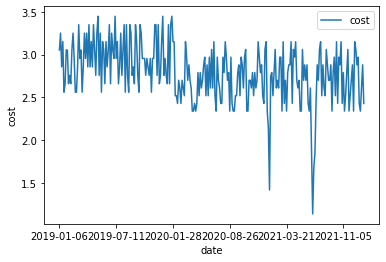

In [20]:
ax = raw_data.plot(x='date', y='cost');
ax.set_xlabel("date")
ax.set_ylabel("cost")

In [21]:
scaler = MinMaxScaler()

cost = raw_data.cost.values.reshape(-1, 1)

scaled_cost = scaler.fit_transform(cost)

In [22]:
np.isnan(scaled_cost).any()

False

In [23]:
scaled_cost = scaled_cost[~np.isnan(scaled_cost)]
scaled_cost = scaled_cost.reshape(-1, 1)
scaled_cost

array([[0.82925318],
       [0.91462659],
       [0.74387977],
       [0.87193988],
       [0.61581965],
       [0.65850636],
       [0.82925318],
       [0.82925318],
       [0.65850636],
       [0.70119306],
       [0.65850636],
       [0.82925318],
       [0.91462659],
       [0.78656647],
       [0.61581965],
       [0.61581965],
       [0.74387977],
       [0.95731329],
       [0.78656647],
       [0.82925318],
       [0.61581965],
       [0.74387977],
       [0.91462659],
       [0.78656647],
       [0.91462659],
       [0.74387977],
       [0.95731329],
       [0.74387977],
       [0.87193988],
       [0.74387977],
       [0.95731329],
       [0.82925318],
       [0.70119306],
       [0.91462659],
       [1.        ],
       [0.70119306],
       [0.91462659],
       [0.61581965],
       [0.87193988],
       [0.82925318],
       [0.65850636],
       [0.87193988],
       [0.74387977],
       [0.82925318],
       [0.95731329],
       [0.65850636],
       [0.91462659],
       [0.829

# Preprocessing

In [69]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_cost, SEQ_LEN, train_split = 0.95)

[[0.82925318]
 [0.91462659]
 [0.74387977]
 [0.87193988]
 [0.61581965]
 [0.65850636]
 [0.82925318]
 [0.82925318]
 [0.65850636]
 [0.70119306]
 [0.65850636]
 [0.82925318]
 [0.91462659]
 [0.78656647]
 [0.61581965]
 [0.61581965]
 [0.74387977]
 [0.95731329]
 [0.78656647]
 [0.82925318]
 [0.61581965]
 [0.74387977]
 [0.91462659]
 [0.78656647]
 [0.91462659]
 [0.74387977]
 [0.95731329]
 [0.74387977]
 [0.87193988]
 [0.74387977]
 [0.95731329]
 [0.82925318]
 [0.70119306]
 [0.91462659]
 [1.        ]
 [0.70119306]
 [0.91462659]
 [0.61581965]
 [0.87193988]
 [0.82925318]
 [0.65850636]
 [0.87193988]
 [0.74387977]
 [0.82925318]
 [0.95731329]
 [0.65850636]
 [0.91462659]
 [0.82925318]
 [0.78656647]
 [1.        ]
 [0.78656647]
 [0.87193988]
 [0.65850636]
 [0.74387977]
 [0.91462659]
 [0.70119306]
 [0.82925318]
 [0.95731329]
 [0.61581965]
 [0.95731329]
 [0.70119306]
 [0.61581965]
 [0.95731329]
 [0.91462659]
 [0.70119306]
 [0.74387977]
 [0.65850636]
 [0.95731329]
 [0.87193988]
 [0.70119306]
 [0.61581965]
 [0.95

In [25]:
X_train.shape

(160, 99, 1)

In [26]:
X_test.shape

(9, 99, 1)

## Model

In [28]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])),
  tf.keras.layers.Dropout(rate=DROPOUT),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM((WINDOW_SIZE * 2), return_sequences=True)),
  tf.keras.layers.Dropout(rate=DROPOUT),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(WINDOW_SIZE, return_sequences=False)),
  tf.keras.layers.Dense(units=1)
])

In [35]:
model.compile(
    loss=tf.keras.losses.Huber(), 
    optimizer='adam',
    metrics=["mae"]
)

In [36]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
3/3 [==============================] - 10s 1s/step - loss: 0.0208 - mae: 0.1693 - val_loss: 0.0133 - val_mae: 0.1352
Epoch 2/50
3/3 [==============================] - 0s 87ms/step - loss: 0.0211 - mae: 0.1617 - val_loss: 0.0085 - val_mae: 0.1126
Epoch 3/50
3/3 [==============================] - 0s 63ms/step - loss: 0.0118 - mae: 0.1231 - val_loss: 0.0101 - val_mae: 0.1157
Epoch 4/50
3/3 [==============================] - 0s 57ms/step - loss: 0.0102 - mae: 0.1055 - val_loss: 0.0087 - val_mae: 0.1123
Epoch 5/50
3/3 [==============================] - 0s 59ms/step - loss: 0.0141 - mae: 0.1283 - val_loss: 0.0073 - val_mae: 0.1076
Epoch 6/50
3/3 [==============================] - 0s 53ms/step - loss: 0.0107 - mae: 0.1144 - val_loss: 0.0094 - val_mae: 0.1145
Epoch 7/50
3/3 [==============================] - 0s 55ms/step - loss: 0.0103 - mae: 0.1103 - val_loss: 0.0074 - val_mae: 0.1085
Epoch 8/50
3/3 [==============================] - 0s 54ms/step - loss: 0.0103 - mae: 0.1087 - val_

In [37]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 43ms/step - loss: 0.0087 - mae: 0.1189


[0.008724161423742771, 0.11885622143745422]

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 99, 198)          79992     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 99, 198)           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 99, 396)          628848    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 99, 396)           0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 198)              392832    
 nal)                                                            
                                                        

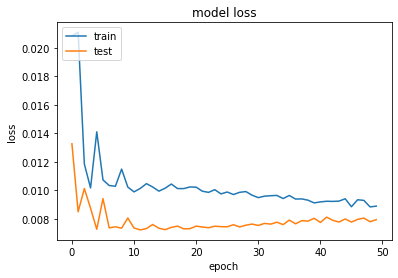

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Text(0.5, 0.98, 'Loss Vs Val Loss')

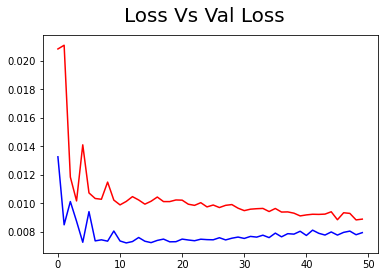

In [40]:
fig = plt.figure()
plt.plot(history.history['loss'], 'r', history.history['val_loss'], 'b')
fig.suptitle('Loss Vs Val Loss', fontsize=20)

Text(0.5, 0.98, 'MAE Vs Val MAE')

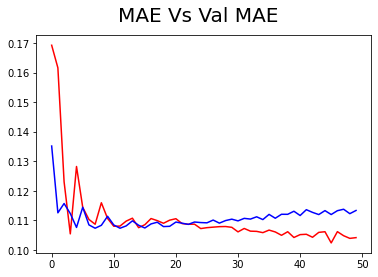

In [41]:
fig = plt.figure()
plt.plot(history.history['mae'], 'r', history.history['val_mae'], 'b')
fig.suptitle('MAE Vs Val MAE', fontsize=20)

# Prediction

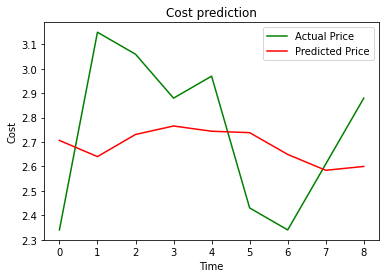

In [42]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Cost prediction')
plt.xlabel('Time')
plt.ylabel('Cost')
plt.legend(loc='best')
 
plt.show();

In [82]:
testing_data = pd.Series(np.array([100000, 200000, 233323, 33233, 222323, 3232313, 232313, 2312333, 132311123]))
testing_data = testing_data.values.reshape(-1, 1)
scaler_testing_data = scaler.fit_transform(testing_data)
scaler_testing_data = scaler_testing_data

In [83]:
testing_sequence = to_sequences(scaler_testing_data, 2)
testing_sequence = testing_sequence[:,-1,:]

In [88]:
forecast = model.predict(testing_sequence)

In [92]:
forecast = scaler.inverse_transform(forecast)

In [93]:
forecast.flatten()

array([11386792., 11389484., 11373320., 11388596., 11631674., 11389402.,
       11557396.], dtype=float32)

In [49]:
model.predict(X_test)

array([[0.6789448 ],
       [0.65023553],
       [0.68953866],
       [0.7045893 ],
       [0.6953036 ],
       [0.6927635 ],
       [0.6541016 ],
       [0.62596136],
       [0.6327288 ]], dtype=float32)

In [91]:
model.save("v2.h5")

In [62]:
X_test.shape

(9, 99, 1)

In [48]:
y_test

array([[0.52004542],
       [0.87107315],
       [0.83207007],
       [0.7540639 ],
       [0.79306699],
       [0.5590485 ],
       [0.52004542],
       [0.63705466],
       [0.7540639 ]])